C:\Users\12822\AppData\Local\Temp\ipykernel_44036\3951846224.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


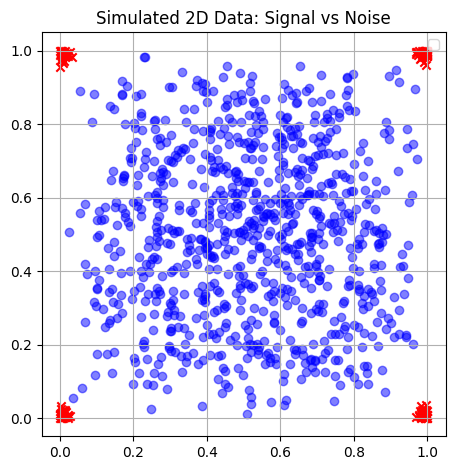

C:\Users\12822\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5070 Ti Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5070 Ti Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


[ready] X: (1000, 2), device=cuda:0, dtype=torch.float32; signal=860, noise1=35, noise2=35, noise3=35, noise4=35


In [1]:
# Cell 1: Initialize dataset X and plot

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import torch

# --- Parameters ---
N = 1000               # Total number of samples
n_noise = 35           # Number of noise samples per corner
n_signal = N - 4 * n_noise
p = 2
np.random.seed(0)    # Reproducibility

# --- Signal from Beta(p,p) x Beta(p,p) ---
signal = np.column_stack((
    beta.rvs(p, p, size=n_signal),
    beta.rvs(p, p, size=n_signal)
))

# --- Noise cluster 1 ---
noise1 = np.column_stack((
    beta.rvs(1, 100, size=n_noise),
    beta.rvs(1, 100, size=n_noise)
))

# --- Noise cluster 2 ---
noise2 = np.column_stack((
    beta.rvs(1, 100, size=n_noise),
    beta.rvs(100, 1, size=n_noise)
))

# --- Noise cluster 3 ---
noise3 = np.column_stack((
    beta.rvs(100, 1, size=n_noise),
    beta.rvs(1, 100, size=n_noise)
))

# --- Noise cluster 4 ---
noise4 = np.column_stack((
    beta.rvs(100, 1, size=n_noise),
    beta.rvs(100, 1, size=n_noise)
))

# --- Combine and arrange ---
X_data = np.vstack([noise1,noise2, signal, noise3, noise4])
noise1_idx = np.arange(0, n_noise)
noise2_idx = np.arange(n_noise, 2 * n_noise)
signal_idx = np.arange(2 * n_noise, n_signal + 2 * n_noise)
noise3_idx = np.arange(n_signal + 2 * n_noise, n_signal + 3 * n_noise)
noise4_idx = np.arange(n_signal + 3 * n_noise, N)


# --- Plot ---
plt.scatter(X_data[signal_idx, 0], X_data[signal_idx, 1], color='blue', alpha=0.5)
plt.scatter(X_data[noise1_idx, 0], X_data[noise1_idx, 1], color='red', marker='x')
plt.scatter(X_data[noise2_idx, 0], X_data[noise2_idx, 1], color='red', marker='x')
plt.scatter(X_data[noise3_idx, 0], X_data[noise3_idx, 1], color='red', marker='x')
plt.scatter(X_data[noise4_idx, 0], X_data[noise4_idx, 1], color='red', marker='x')
plt.legend()
plt.grid(True)
plt.title("Simulated 2D Data: Signal vs Noise")
plt.axis('square')
plt.tight_layout()
plt.show()

# ---------------------- Below: make dataset ready for later usage ----------------------
# (No changes to the original content above.)
_mps_ok = getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if _mps_ok else "cpu"))
X = torch.tensor(X_data, dtype=torch.get_default_dtype(), device=device)
M = X.shape[0]

# Boolean masks as tensors (useful for later diagnostics/plots)
signal_mask = torch.zeros(M, dtype=torch.bool, device=device); signal_mask[signal_idx] = True
noise1_mask = torch.zeros(M, dtype=torch.bool, device=device); noise1_mask[noise1_idx] = True
noise2_mask = torch.zeros(M, dtype=torch.bool, device=device); noise2_mask[noise2_idx] = True
noise3_mask = torch.zeros(M, dtype=torch.bool, device=device); noise3_mask[noise3_idx] = True
noise4_mask = torch.zeros(M, dtype=torch.bool, device=device); noise4_mask[noise4_idx] = True

# Bounds often needed for grids/visualization
x_min, y_min = X_data.min(axis=0).astype(float)
x_max, y_max = X_data.max(axis=0).astype(float)

# Small bundle for convenience
dataset = {
    "X": X,
    "M": M,
    "idx_np": {"signal": signal_idx, "noise1": noise1_idx, "noise2": noise2_idx, "noise3": noise3_idx, "noise4": noise4_idx},
    "mask_t": {"signal": signal_mask, "noise1": noise1_mask, "noise2": noise2_mask, "noise3": noise3_mask, "noise4": noise4_mask},
    "bounds": (float(x_min), float(x_max), float(y_min), float(y_max)),
    "device": str(device),
}

print(f"[ready] X: {tuple(X.shape)}, device={X.device}, dtype={X.dtype}; "
        f"signal={signal_mask.sum().item()}, noise1={noise1_mask.sum().item()}, "
        f"noise2={noise2_mask.sum().item()}, noise3={noise3_mask.sum().item()}, "
        f"noise4={noise4_mask.sum().item()}")


In [2]:
from torch import nn

class CriticNet(nn.Module):
    def __init__(self, d_in=2, hidden=(256, 256), neg_slope=0.2, dropout=0.0):
        """
        Minimal critic for WGAN-GP.
        - d_in: input dimension (2 for your Beta×Beta toy data)
        - hidden: tuple of hidden layer sizes
        - neg_slope: LeakyReLU slope
        - dropout: optional, usually 0.0 for critic
        """
        super().__init__()
        layers = []
        last = d_in
        for h in hidden:
            layers += [nn.Linear(last, h), nn.LeakyReLU(neg_slope)]
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            last = h
        layers += [nn.Linear(last, 1)]  # scalar output
        self.net = nn.Sequential(*layers)
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, a=0.2, nonlinearity='leaky_relu')
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x).squeeze(-1)

In [3]:
from torch.distributions import Beta as TorchBeta
torch.manual_seed(0)
p_theta = 2

def make_beta_prod_sampler(p: float, device=None, dtype=None):
    device = device or X.device
    dtype  = dtype  or X.dtype
    conc   = torch.full((2,), float(p), device=device, dtype=dtype)
    dist   = TorchBeta(conc, conc)
    def sample(m: int):
        return dist.rsample((m,)) if getattr(dist, "has_rsample", False) else dist.sample((m,))
    return sample

sample_F_theta = make_beta_prod_sampler(p_theta)

In [4]:
def build_minibatch_data(
    X, w, sample_F_theta, real_bs, fake_bs, *,
    replace=True,
    sample_real_by_weight=True,
):
    """
    If sample_real_by_weight=True:
        idx_real ~ Categorical(w), and you should use real_scores.mean() later.
    If sample_real_by_weight=False (uniform):
        idx_real ~ Uniform({0..N-1}), and you should use (w_batch * real_scores).sum().
    """
    device, dtype = X.device, X.dtype
    N = X.shape[0]

    # sanitize weights to simplex
    w = w.to(device=device, dtype=dtype).flatten().clamp_min(0)
    w = w / (w.sum() + 1e-12)

    # sample real indices
    if sample_real_by_weight:
        idx_real = torch.multinomial(w, num_samples=real_bs, replacement=replace)
    else:
        idx_real = torch.randint(0, N, (real_bs,), device=device)

    # gather real batch + batch weights (renormalized)
    X_real  = X.index_select(0, idx_real)
    w_batch = w.index_select(0, idx_real)
    w_batch = w_batch / (w_batch.sum() + 1e-12)

    # fake from F_theta
    Z_fake = sample_F_theta(fake_bs).to(device=device, dtype=dtype)

    return X_real, w_batch, Z_fake, idx_real

In [5]:
def critic_forward_objective(
    phi, X_real, w_batch, Z_fake, *,
    gp_lambda: float = 0.0,
    gp_center: float = 1.0,
    use_weighted_real: bool = False,
    iw_fake: torch.Tensor | None = None
):
    device, dtype = X_real.device, X_real.dtype

    real_scores = phi(X_real).reshape(-1)
    fake_scores = phi(Z_fake).reshape(-1)

    # E_Q[f]
    if use_weighted_real:
        real_term = (w_batch.to(device, dtype) * real_scores).sum()
    else:
        real_term = real_scores.mean()

    # E_F[f]
    if iw_fake is None:
        fake_term = fake_scores.mean()
    else:
        wF = iw_fake.to(device, dtype)
        wF = wF / (wF.sum() + 1e-12)
        fake_term = (wF * fake_scores).sum()

    J = real_term - fake_term
    loss = -J

    # WGAN-GP
    if gp_lambda > 0.0:
        br = X_real.shape[0]
        eps = torch.rand(br, 1, device=device, dtype=dtype)
        if Z_fake.shape[0] < br:
            reps = (br + Z_fake.shape[0] - 1) // Z_fake.shape[0]
            Zf = Z_fake.repeat(reps, 1)[:br]
        else:
            Zf = Z_fake[:br]
        x_hat = (eps * X_real + (1 - eps) * Zf).requires_grad_(True)
        f_hat = phi(x_hat).reshape(-1)
        grads = torch.autograd.grad(
            outputs=f_hat, inputs=x_hat, grad_outputs=torch.ones_like(f_hat),
            create_graph=True, retain_graph=False, only_inputs=True
        )[0]
        gp = ((grads.norm(2, dim=1).clamp_min(1e-12) - gp_center) ** 2).mean()
        loss = loss + gp_lambda * gp
    else:
        gp = torch.tensor(0.0, device=device, dtype=dtype)

    stats = {
        "J": float(J.detach().cpu()),
        "real": float(real_term.detach().cpu()),
        "fake": float(fake_term.detach().cpu()),
        "gp": float(gp.detach().cpu()),
    }
    return loss, J, stats

In [6]:
def lipschitz_control_wgan_gp(
    phi,
    X_real,          # [B_r, d]
    Z_fake,          # [B_f, d]
    *,
    gp_lambda: float = 10.0,
    gp_center: float = 1.0,
):
    """
    Recommended Lipschitz control: WGAN-GP.
    Computes the gradient penalty term:
        gp_lambda * E[(||∇_x f_phi(x_hat)||_2 - gp_center)^2]
    where x_hat is a random interpolation between real and fake.

    Returns:
      penalty : scalar tensor (add to your loss)
      stats   : dict with detached floats for logging
    """
    device, dtype = X_real.device, X_real.dtype
    br = X_real.shape[0]
    Z_fake = Z_fake.to(device=device, dtype=dtype)

    if Z_fake.shape[0] < br:
        reps = (br + Z_fake.shape[0] - 1) // Z_fake.shape[0]
        Zf = Z_fake.repeat(reps, 1)[:br]
    else:
        Zf = Z_fake[:br]

    # Interpolate between real and fake
    eps = torch.rand(br, 1, device=device, dtype=dtype)
    x_hat = eps * X_real + (1.0 - eps) * Zf
    x_hat.requires_grad_(True)

    # Critic on interpolates
    f_hat = phi(x_hat).reshape(-1)
    grad_outputs = torch.ones_like(f_hat)

    # Gradients
    grads = torch.autograd.grad(
        outputs=f_hat, inputs=x_hat, grad_outputs=grad_outputs,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]  # [br, d]

    grad_norm = grads.norm(2, dim=1)
    penalty = gp_lambda * ((grad_norm - gp_center) ** 2).mean()

    stats = {
        "gp": float(penalty.detach().cpu()),
        "grad_norm_mean": float(grad_norm.detach().mean().cpu()),
        "grad_norm_std": float(grad_norm.detach().std(unbiased=False).cpu()),
    }
    return penalty, stats

In [7]:
def optimizer_plumbing_step(
    loss,
    optimizer,
    module=None,
    *,
    use_amp: bool = False,
    scaler: torch.cuda.amp.GradScaler | None = None,
    max_grad_norm: float | None = None,
    weight_clip_value: float | None = None,
):
    """
    One-shot optimizer plumbing:
      - zero grad
      - (AMP) backward
      - (optional) grad clipping
      - optimizer step
      - (optional) weight clipping

    Parameters
    ----------
    loss : torch.Tensor (scalar)
        The loss to backpropagate.
    optimizer : torch.optim.Optimizer
        Optimizer to step.
    module : torch.nn.Module | None
        If provided and weight_clip_value is not None, clip params of this module after step.
    use_amp : bool
        Use automatic mixed precision (AMP).
    scaler : torch.cuda.amp.GradScaler | None
        GradScaler to use when use_amp=True. If None, a new one is created.
    max_grad_norm : float | None
        If set, clip gradient norm to this value.
    weight_clip_value : float | None
        If set and module is provided, clamp parameters to [-value, value] after step.

    Returns
    -------
    stats : dict
        {
          "loss": float,
          "grad_norm": float | None
        }
    """
    optimizer.zero_grad(set_to_none=True)

    grad_norm_value = None

    if use_amp:
        from torch import amp
        scaler = scaler or amp.GradScaler(enabled=True)
        scaler.scale(loss).backward()
        if max_grad_norm is not None:
            scaler.unscale_(optimizer)
            grad_norm_value = float(torch.nn.utils.clip_grad_norm_(module.parameters(), max_grad_norm).detach().cpu()) \
                              if module is not None else None
        scaler.step(optimizer)
        scaler.update()
    else:
        loss.backward()
        if max_grad_norm is not None:
            grad_norm_value = float(torch.nn.utils.clip_grad_norm_(module.parameters(), max_grad_norm).detach().cpu()) \
                              if module is not None else None
        optimizer.step()

    if (weight_clip_value is not None) and (module is not None):
        for p in module.parameters():
            if p is not None:
                p.data.clamp_(-weight_clip_value, weight_clip_value)

    return {"loss": float(loss.detach().cpu()), "grad_norm": grad_norm_value}

In [8]:
def monitor_critic_training_step(
    step: int,
    stats: dict,                    # e.g., from critic_forward_objective / critic_objective_fixed_w: {"J","H","L","gp","real","fake","g_mean","g_std",...}
    history: list,                  # mutable list to store per-step records (append-only)
    state: dict | None = None,      # mutable state carried across calls; can be None on first call
    *,
    opt_stats: dict | None = None,  # e.g., from optimizer_plumbing_step: {"loss","grad_norm"}
    log_every: int = 10,
    ema_keys: tuple[str, ...] = ("J", "loss"),  # which keys to maintain EMA for (if present)
    ema_beta: float = 0.9,          # EMA decay (higher = smoother)
    early_stop_key: str = "J",      # metric to monitor for early stopping (maximize)
    early_stop_window: int = 40,    # steps per window
    early_stop_tol: float = 5e-5,   # relative improvement threshold across consecutive windows
    print_fn=None                   # custom logger; defaults to built-in print
):
    """
    One-stop monitoring utility:
      - merges stats and opt_stats
      - appends a per-step record to history
      - maintains EMA for selected keys in 'state'
      - checks early stopping via windowed best-improvement on early_stop_key
      - prints concise logs every 'log_every' steps

    Returns:
      early_stop (bool), state (dict)
    """
    if print_fn is None:
        print_fn = print

    # --- init state ---
    if state is None or not isinstance(state, dict):
        state = {"ema": {}, "nonfinite_count": 0}

    # --- combine stats ---
    record = {"step": int(step)}
    if stats:
        for k, v in stats.items():
            # accept torch/scalar/float; coerce to float if possible
            try:
                record[k] = float(v)
            except Exception:
                record[k] = v
    if opt_stats:
        for k, v in opt_stats.items():
            try:
                record[k] = float(v)
            except Exception:
                record[k] = v

    # --- non-finite guard ---
    nonfinite_keys = []
    for k, v in list(record.items()):
        if isinstance(v, float) and (v != v or v == float("inf") or v == float("-inf")):  # NaN/Inf check
            nonfinite_keys.append(k)
    if nonfinite_keys:
        state["nonfinite_count"] = state.get("nonfinite_count", 0) + 1
        # replace non-finite with last finite value if available, otherwise zero
        if history:
            last = history[-1]
            for k in nonfinite_keys:
                record[k] = last.get(k, 0.0)
        else:
            for k in nonfinite_keys:
                record[k] = 0.0

    # --- update EMAs for selected keys (only if present) ---
    for k in ema_keys:
        if k in record and isinstance(record[k], float):
            prev = state["ema"].get(k, record[k])
            state["ema"][k] = ema_beta * prev + (1.0 - ema_beta) * record[k]
            record[f"ema_{k}"] = state["ema"][k]

    # --- append to history ---
    history.append(record)

    # --- early stopping: compare windowed bests of early_stop_key ---
    early_stop = False
    if early_stop_key in record and isinstance(record[early_stop_key], float):
        n = len(history)
        if n >= 2 * early_stop_window:
            # previous window: [n-2w, n-w), recent window: [n-w, n)
            prev_best = max(h.get(early_stop_key, float("-inf")) for h in history[n - 2 * early_stop_window : n - early_stop_window])
            recent_best = max(h.get(early_stop_key, float("-inf")) for h in history[n - early_stop_window : n])
            # relative improvement
            denom = max(1.0, abs(prev_best))
            rel_improve = (recent_best - prev_best) / denom
            record["recent_best"] = recent_best
            record["prev_best"] = prev_best
            record["rel_improve"] = rel_improve
            early_stop = rel_improve < early_stop_tol

    # --- periodic logging ---
    if (log_every is not None) and (step % log_every == 0):
        parts = [f"[critic] step {step:5d}"]
        for k in ("J", "H", "L", "gp", "loss", "grad_norm"):
            if k in record and isinstance(record[k], float):
                parts.append(f"{k}={record[k]:.6f}")
        for k in ema_keys:
            kk = f"ema_{k}"
            if kk in record and isinstance(record[kk], float):
                parts.append(f"{kk}={record[kk]:.6f}")
        if "rel_improve" in record:
            parts.append(f"Δ_rel={record['rel_improve']:.3e}")
        print_fn("  ".join(parts))

    return early_stop, state


In [9]:
def critic_update(
    step: int,
    *,
    phi,                         # critic nn.Module
    optimizer,                   # torch.optim.Optimizer for phi
    X,                           # [N, d]
    w,                           # [N]
    sample_F_theta,              # callable(m) -> [m, d] from F_theta  (used if fake_sampler=None)
    real_bs: int,
    fake_bs: int,
    gp_lambda: float = 10.0,
    gp_center: float = 1.0,
    use_amp: bool = False,
    scaler=None,
    max_grad_norm: float | None = None,
    weight_clip_value: float | None = None,
    history: list | None = None,
    state: dict | None = None,
    log_every: int = 10,
    print_fn=None,

    # -------- NEW toggles / hooks --------
    sample_real_by_weight: bool = False,     # False => uniform real sampling (recommended)
    use_weighted_real: bool | None = None,   # None => infer from sampling mode
    fake_sampler=None,                       # Optional: callable(fake_bs)->(Z_fake, iw_fake) for tail IS
):
    """
    One critic training step with optional:
      - uniform real sampling + SNIS (recommended) OR sample-by-w + mean (classic)
      - fake importance sampling via `fake_sampler`
    """
    # data + sampling
    # If sample_real_by_weight=True: X_real ~ Q; else: X_real ~ Uniform and we pass w_batch for SNIS
    X_real, w_batch, Z_fake, idx_real = build_minibatch_data(
        X, w, sample_F_theta, real_bs, fake_bs,
        replace=True,
        sample_real_by_weight=sample_real_by_weight,
    )

    # optional: replace Z_fake with an importance-sampled proposal + weights
    iw_fake = None
    if callable(fake_sampler):
        Z_fake, iw_fake = fake_sampler(fake_bs)
        Z_fake = Z_fake.to(device=X.device, dtype=X.dtype)
        if iw_fake is not None:
            iw_fake = iw_fake.to(device=X.device, dtype=X.dtype)

    # Decide how to aggregate the real term:
    #  - If we sampled by weight: unbiased simple mean (use_weighted_real=False)
    #  - If we sampled uniformly: SNIS (use_weighted_real=True)
    if use_weighted_real is None:
        use_weighted_real = not sample_real_by_weight

    # base objective (no GP)
    base_loss, J, obj_stats = critic_forward_objective(
        phi, X_real, w_batch, Z_fake,
        gp_lambda=0.0,                    # keep GP out
        gp_center=gp_center,
        use_weighted_real=use_weighted_real,
        iw_fake=iw_fake
    )

    # Lipschitz control (WGAN-GP)
    gp_term = 0.0
    gp_stats = {}
    if gp_lambda and gp_lambda > 0.0:
        # your external GP helper (unchanged)
        penalty, gp_stats = lipschitz_control_wgan_gp(
            phi, X_real, Z_fake, gp_lambda=gp_lambda, gp_center=gp_center
        )
        loss_total = base_loss + penalty
        gp_term = gp_stats.get("gp", float(penalty.detach().cpu()))
    else:
        loss_total = base_loss

    # optimizer plumbing
    opt_stats = optimizer_plumbing_step(
        loss_total, optimizer, module=phi,
        use_amp=use_amp, scaler=scaler,
        max_grad_norm=max_grad_norm, weight_clip_value=weight_clip_value,
    )

    # monitoring/logging
    merged_stats = {}
    merged_stats.update(obj_stats)           # J, real, fake, (and gp=0 from objective)
    if gp_lambda and gp_lambda > 0.0:
        merged_stats.update({"gp": gp_term})
        for k in ("grad_norm_mean", "grad_norm_std"):
            if k in gp_stats:
                merged_stats[k] = gp_stats[k]

    early_stop, state = monitor_critic_training_step(
        step=step,
        stats=merged_stats,
        history=(history if history is not None else []),
        state=state,
        opt_stats=opt_stats,
        log_every=log_every,
        ema_keys=("J", "loss"),
        ema_beta=0.9,
        early_stop_key="J",
        early_stop_window=40,
        early_stop_tol=5e-5,
        print_fn=print_fn
    )

    record = {"step": step}
    record.update(merged_stats)
    record.update(opt_stats)
    return record, early_stop, state, idx_real

In [10]:
@torch.no_grad()
def weights_update(self, X=None, lam=None, eps_mix=1e-3):
    """
    Closed-form ETEL weight update with WGAN critic:
        w ∝ exp(-λ * f_phi(X))  i.e.  w = softmax(-λ * f_phi(X))
    Optionally mix with uniform by eps_mix to avoid degeneracy.
    """
    x = X if X is not None else self.X                    # [n, d]
    lam = float(lam if lam is not None else self.lambda_w)
    
    f = self.phi(x).flatten().detach()                    # [n]
    f_nrm = (f - f.mean()) / (f.std(unbiased=False).clamp_min(1e-8))
    f_nrm = f_nrm.clamp(-3.0, 3.0)
    logits = -lam * f_nrm
    logits = logits - logits.max()                        # numerical stability
    w = torch.softmax(logits, dim=0)                      # [n]

    if eps_mix and eps_mix > 0:
        n = w.numel()
        w = (1.0 - eps_mix) * w + eps_mix / n

    w = w / w.sum()                                       # exact simplex
    if not torch.isfinite(w).all():                       # safety fallback
        n = x.shape[0]
        w = torch.full((n,), 1.0 / n, device=x.device, dtype=x.dtype)

    self.w = w                                            # store (buffer)
    return w

In [11]:
# ===== Minimal main loop (init once, then call helpers) =====
import torch
from types import SimpleNamespace

# Hyperparams
T_outer       = 1000
C_per_round   = 50
real_bs       = 512
fake_bs       = 2048
gp_lambda     = 10.0
gp_center     = 1.0
lambda_w      = 2.5
eps_mix       = 1e-4
use_amp       = (X.device.type == "cuda")

# critic & optimizer
phi = CriticNet(d_in=2, hidden=(256, 256)).to(X.device)
opt = torch.optim.Adam(phi.parameters(), lr=3e-4, betas=(0.5, 0.9))

# initialize weights
w0 = torch.full((M,), 1.0 / M, device=X.device, dtype=X.dtype)

# bind weights_update() by giving it a simple context
ctx = SimpleNamespace(phi=phi, X=X, lambda_w=lambda_w, w=w0)

history, state = [], None
step = 0

for t in range(1, T_outer + 1):
    # critic updates with current weights
    early = False
    for _ in range(C_per_round):
        step += 1
        _, early, state, _ = critic_update(
            step=step,
            phi=phi, optimizer=opt,
            X=X, w=ctx.w,
            sample_F_theta=sample_F_theta,
            real_bs=real_bs, fake_bs=fake_bs,
            gp_lambda=gp_lambda, gp_center=gp_center,
            use_amp=use_amp, scaler=None,
            history=history, state=state,
            log_every=100,
            print_fn=None
        )
        early=False
        if early:
            print("[early]", state)
            break

    # weight update
    weights_update(ctx, eps_mix=eps_mix)

    # record every 100 rounds
    if t % 100 == 0 or t == 1:
        with torch.no_grad():
            H = float((-(ctx.w * ctx.w.clamp_min(1e-12).log())).sum().cpu())
            print(f"[round {t:03d}] H(w)={H:.4f}  w[min,max]=({ctx.w.min().item():.2e}, {ctx.w.max().item():.2e})")
    if early:
        print(f"Early stop at round {t}.")
        break

# expose results
trained = {
    "phi": phi,
    "optimizer": opt,
    "w": ctx.w,
    "lambda_w": lambda_w,
    "gp_lambda": gp_lambda,
    "history": history,
    "state": state,
}

C:\Users\12822\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[round 001] H(w)=4.6864  w[min,max]=(1.39e-07, 2.24e-02)
[critic] step   100  J=0.596984  gp=0.336975  loss=-0.260009  ema_J=0.366496  ema_loss=0.009037  Δ_rel=6.608e-01
[critic] step   200  J=-0.449822  gp=0.244762  loss=0.694585  ema_J=-0.383090  ema_loss=0.573200  Δ_rel=-1.391e-01
[critic] step   300  J=-0.255865  gp=0.328768  loss=0.584633  ema_J=-0.312332  ema_loss=0.455542  Δ_rel=2.483e-02
[critic] step   400  J=-0.277207  gp=0.156927  loss=0.434135  ema_J=-0.317716  ema_loss=0.467961  Δ_rel=1.251e-02
[critic] step   500  J=-0.274423  gp=0.087474  loss=0.361897  ema_J=-0.290569  ema_loss=0.403290  Δ_rel=-5.011e-03
[critic] step   600  J=-0.239367  gp=0.239884  loss=0.479251  ema_J=-0.294191  ema_loss=0.399204  Δ_rel=-1.976e-02
[critic] step   700  J=-0.295951  gp=0.107446  loss=0.403397  ema_J=-0.313872  ema_loss=0.427345  Δ_rel=-1.369e-02
[critic] step   800  J=-0.289218  gp=0.088938  loss=0.378157  ema_J=-0.307112  ema_loss=0.439712  Δ_rel=-6.126e-03
[critic] step   900  J=-0.1

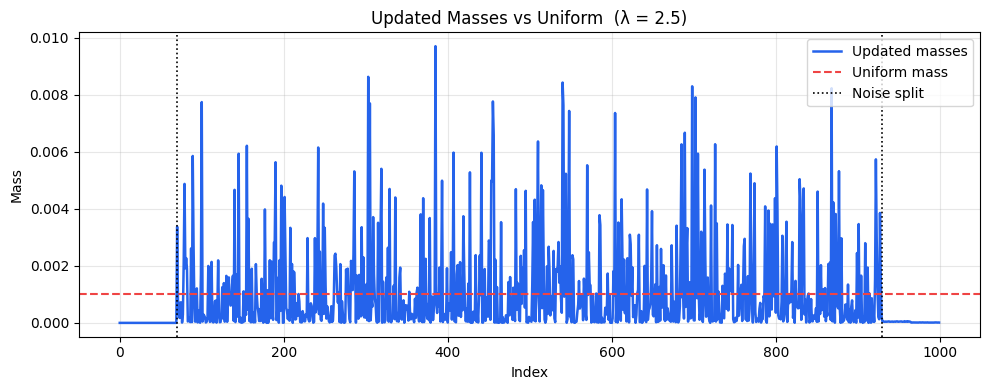

In [12]:
# ===== Plot updated masses vs uniform (with noise index markers) =====
w_t = trained["w"]
w_np = w_t.detach().cpu().numpy() if isinstance(w_t, torch.Tensor) else np.asarray(w_t)
N = w_np.size
uniform_mass = 1.0 / N
lam_disp = float(trained.get("lambda_w", 0.0))

# noise boundaries from how X_data was stacked
n_signal = len(dataset["idx_np"]["signal"])
n_noise  = len(dataset["idx_np"]["noise1"])
i_noise1_end = 2 * n_noise
i_noise2_start = n_signal + 2 * n_noise

# plot
x = np.arange(N)
plt.figure(figsize=(10,4))
plt.plot(x, w_np, lw=1.8, color="#2563eb", label="Updated masses")
plt.axhline(uniform_mass, color="#ef4444", ls="--", lw=1.5, label="Uniform mass")
plt.axvline(i_noise1_end-0.5, color="k", ls=":", lw=1.2, label="Noise split")
plt.axvline(i_noise2_start-0.5, color="k", ls=":", lw=1.2)

plt.title(f"Updated Masses vs Uniform  (λ = {lam_disp:g})")
plt.xlabel("Index")
plt.ylabel("Mass")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

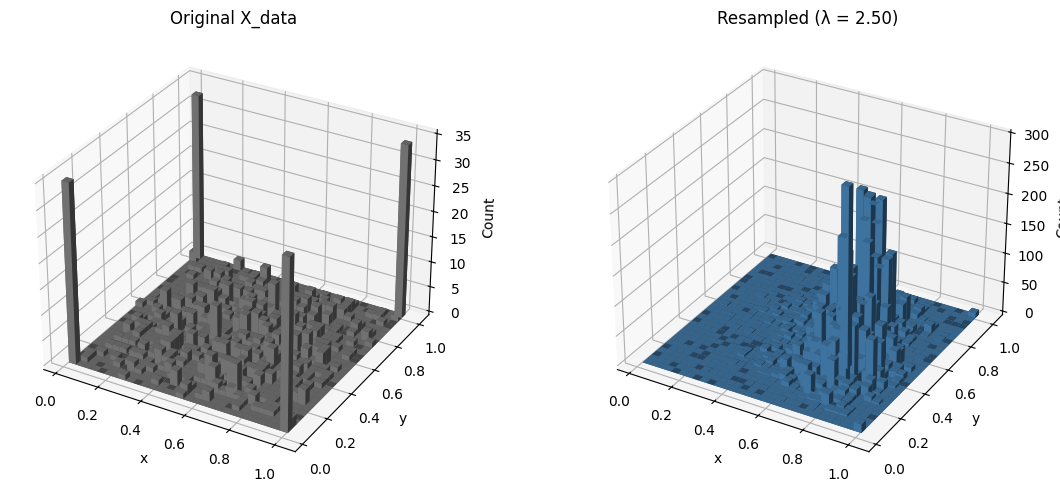

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import math

# --- knobs ---
bins = 30
num_resample = 10_000
rng = np.random.default_rng(0)

# --- grab weights (torch or numpy) ---
try:
    import torch
    w_src = ctx.w if "ctx" in globals() and hasattr(ctx, "w") else final_masses
    if isinstance(w_src, torch.Tensor):
        w_np = w_src.detach().float().cpu().numpy()
    else:
        w_np = np.asarray(w_src, dtype=np.float64)
except NameError:
    # if torch/final_masses/ctx aren't defined, fall back to uniform
    w_np = np.full(len(X_data), 1.0 / len(X_data), dtype=np.float64)

# sanitize to a simplex
w_np = np.clip(w_np, 0, None)
w_sum = w_np.sum()
w_np = (np.full_like(w_np, 1.0 / len(w_np)) if (not np.isfinite(w_sum) or w_sum <= 0) else (w_np / w_sum))

# --- histogram grid (use same edges for both plots) ---
H1, xedges, yedges = np.histogram2d(X_data[:, 0], X_data[:, 1],
                                    bins=bins, range=[[0, 1], [0, 1]])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
xpos, ypos = np.meshgrid(xcenters, ycenters, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dx = dy = 1.0 / bins
dz1 = H1.ravel()

# --- resample according to weights ---
idx = rng.choice(len(X_data), size=num_resample, replace=True, p=w_np)
resampled = X_data[idx]
H2, _, _ = np.histogram2d(resampled[:, 0], resampled[:, 1], bins=[xedges, yedges])
dz2 = H2.ravel()

# --- pretty title with lambda if available ---
lam_val = None
if "lambda_w" in globals():
    lam_val = float(lambda_w)
elif "ctx" in globals() and hasattr(ctx, "lambda_w"):
    lam_val = float(ctx.lambda_w)

lam_title = f"λ = {lam_val:.2f}" if lam_val is not None else "resampled by w"

# --- plot ---
fig = plt.figure(figsize=(12, 5))

ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax0.bar3d(xpos, ypos, zpos, dx, dy, dz1, color='gray', zsort='average')
ax0.set_title("Original X_data")
ax0.set_xlabel("x"); ax0.set_ylabel("y"); ax0.set_zlabel("Count")

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz2, color='steelblue', zsort='average')
ax1.set_title(f"Resampled ({lam_title})")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("Count")

plt.tight_layout()
plt.show()


In [14]:
with torch.no_grad():
    w = ctx.w.detach()
    N = w.numel()
    u = 1.0 / N
    ess = 1.0 / (w*w).sum()
    ess_frac = float(ess / N)
    wmax = float(w.max())
    peak_factor = wmax / u
    topk = [1,5,10,20,50, max(1, N//100)]
    cum = {k: float(w.topk(min(k, N)).values.sum().cpu()) for k in topk}
    H = float((-(w.clamp_min(1e-12)*w.clamp_min(1e-12).log())).sum().cpu())
    print(dict(ESS_frac=round(ess_frac,3),
               peak_factor=round(peak_factor,1),
               top_mass={k: round(v,3) for k,v in cum.items()},
               entropy=round(H,3)))

{'ESS_frac': 0.294, 'peak_factor': 9.7, 'top_mass': {1: 0.01, 5: 0.043, 10: 0.082, 20: 0.148, 50: 0.303}, 'entropy': 6.011}


In [15]:
with torch.no_grad():
    masses = {k: float(ctx.w[m].sum().cpu()) for k,m in dataset["mask_t"].items()}
    print({k: round(v,4) for k,v in masses.items()})     # want noise* <= 0.01 each

{'signal': 0.9979, 'noise1': 0.0, 'noise2': 0.0, 'noise3': 0.0016, 'noise4': 0.0005}
